In [1]:
from pathlib import Path
import sys 
sys.path.insert(0, "/forecaster/src")

import matplotlib.pyplot as plt 
import numpy as np 
import jax.numpy as jnp 
from jax import jit, grad, vmap 
from tabulate import tabulate

from dataset import ForecastingConfig, ForecastingDataset, SegmentationConfig, SegmentationDataset
from metrics import rms, percentage_error
from models import last_value, RunningAverage

## Stanford Benchmark
  * 11 benchmarks, very simple
  * Winsorized (beginning and end of timeseries are clipped during preprocessing)

2023-07-31 23:45:11,417 INFO Deserialized source data from: /forecaster/data/aggregated.pkl


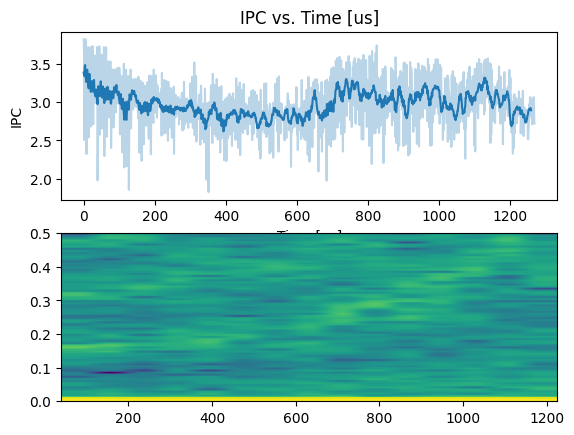

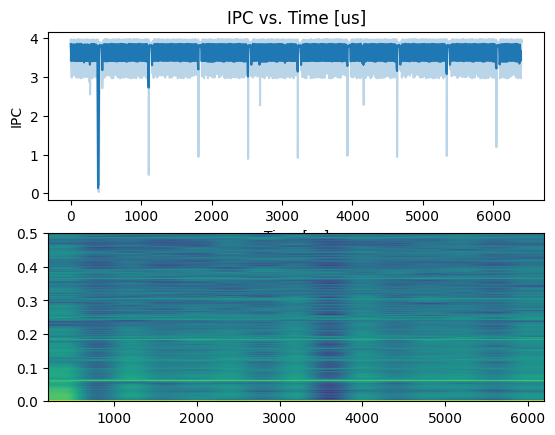

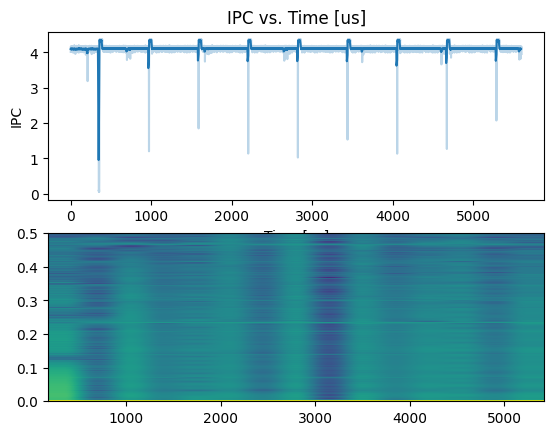

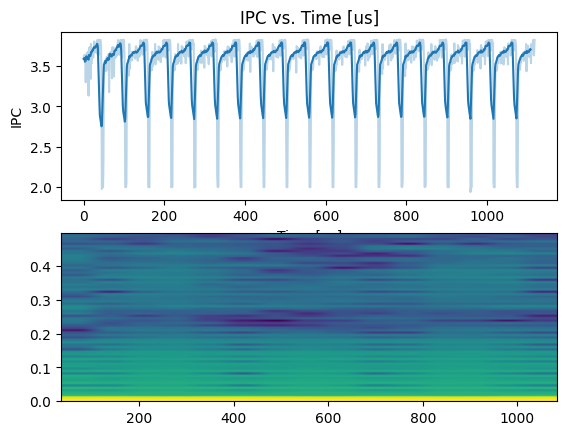

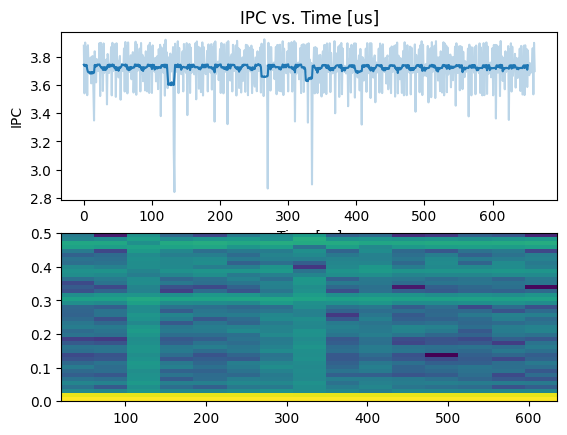

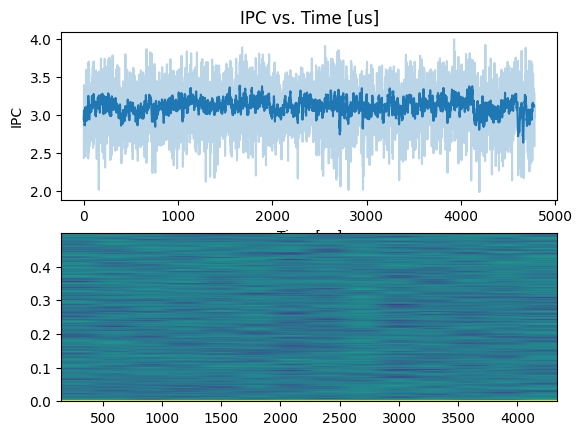

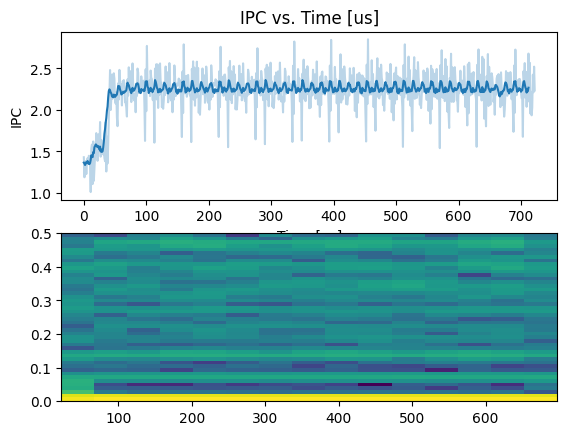

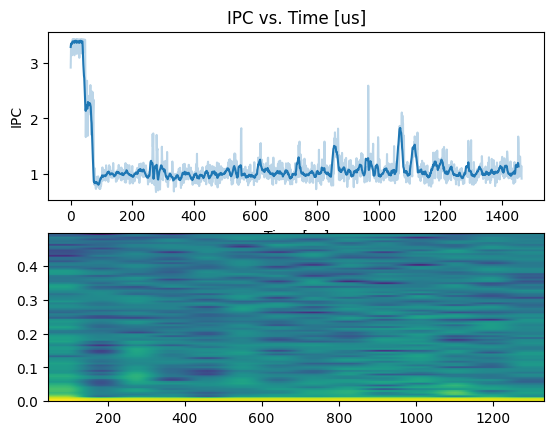

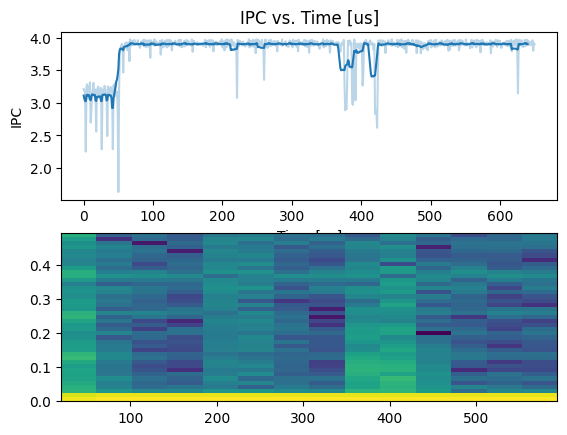

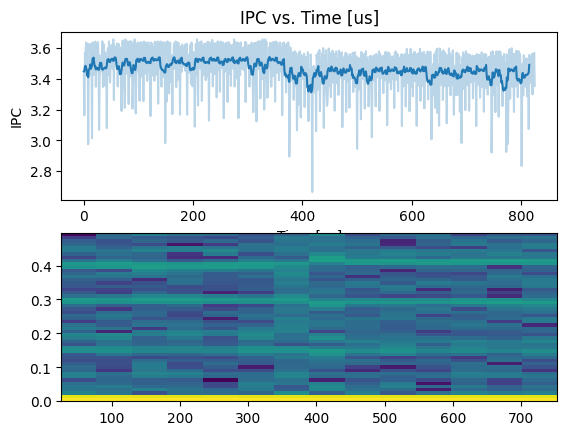

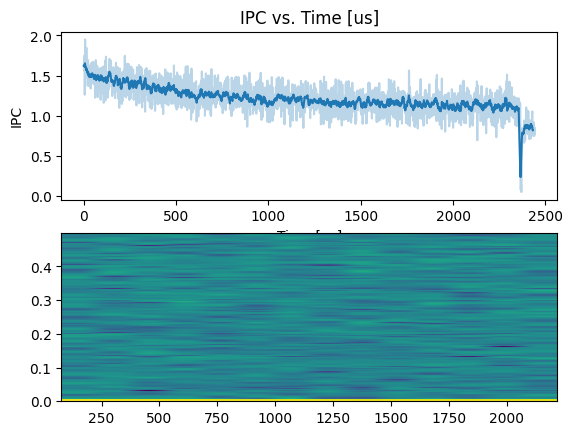

In [32]:
%matplotlib inline 

data_config = SegmentationConfig(
    data_source=Path("/forecaster/data/aggregated.pkl"), 
)
segmentation_dataset = SegmentationDataset(data_config) 

smooth: callable = lambda x, order=10: np.convolve(np.ones(order)/order, x, mode='same')

for i, ts in enumerate(segmentation_dataset.data): 
    fig, (ax1, ax2) = plt.subplots(nrows=2)
    ax1.set_title("IPC vs. Time [us]")
    ax1.set_xlabel("Time [us]")
    ax1.set_ylabel("IPC")

    x = segmentation_dataset.data[i]

    ax1.plot(x, c="tab:blue", alpha=0.3)
    ax1.plot(smooth(x)[5:-5], c="tab:blue")

    _ = ax2.specgram(x, NFFT=x.size // 8, Fs=1, noverlap=x.size // 16)

    plt.show()

## Forecasting Dataset
  * Can be cut into arbitrary length history windows (default 3) and rollout windows (default 1) 

In [3]:
data_config = ForecastingConfig(
    data_source=Path("/forecaster/data/aggregated.pkl"), 
    aggregate_benchmarks=True
)
dataset = ForecastingDataset(data_config) 
dataset

2023-07-28 18:24:54,121 INFO Starting setup...
2023-07-28 18:24:54,380 INFO Deserialized source data from: /forecaster/data/aggregated.pkl
2023-07-28 18:24:54,403 INFO Aggregating predictors and targets across benchmarks
2023-07-28 18:24:54,413 INFO Finished setup...


ForecastingDataset(config=ForecastingConfig(data_source=PosixPath('/forecaster/data/aggregated.pkl'), model_memory=3, rollout=1, predictors='ipc', targets='ipc', winsorize=True, front_clip_proportion=0.05, back_clip_proportion=0.05, aggregate_benchmarks=True, train_proportion=0.7, validation_proportion=0.2, test_proportion=0.1), initialized=True, size=299.5 KB)

## Baselines 
  * Last-value predictor 
  * Running average predictor 

In [4]:
validation_inputs: np.ndarray = dataset.data["validation_predictors"]
validation_targets: np.ndarray = dataset.data["validation_targets"]

In [5]:
validation_predictions: np.ndarray = vmap(last_value)(validation_inputs)
print("Model: last value predictor")
print(f"Target RMS: {rms(validation_targets):0.3f}")
print(f"RMS Error: {rms(validation_predictions - validation_targets):0.3f}")
print(f"Percentage Error: {percentage_error(validation_predictions, validation_targets):0.3f}%")

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


Model: last value predictor
Target RMS: 3.340
RMS Error: 1.416
Percentage Error: 42.389%


In [6]:
model = RunningAverage()
validation_predictions: np.ndarray = model.evaluate(validation_inputs)
print("Model: last value predictor")
print(f"Target RMS: {rms(validation_targets):0.3f}")
print(f"RMS Error: {rms(validation_predictions - validation_targets):0.3f}")
print(f"Percentage Error: {percentage_error(validation_predictions, validation_targets):0.3f}%")

Model: last value predictor
Target RMS: 3.340
RMS Error: 1.073
Percentage Error: 32.120%


In [7]:
train_inputs: np.ndarray = dataset.data["train_predictors"]
train_targets: np.ndarray = dataset.data["train_targets"]

In [12]:
x = np.linalg.solve(train_inputs.T @ train_inputs, train_inputs.T @ train_targets)
validation_predictions: np.ndarray = validation_inputs @ x 
print("Model: linear autoregressive")
print(f"Target RMS: {rms(validation_targets):0.3f}")
print(f"RMS Error: {rms(validation_predictions - validation_targets):0.3f}")
print(f"Percentage Error: {percentage_error(validation_predictions, validation_targets):0.3f}%")

Model: linear autoregressive
Target RMS: 3.340
RMS Error: 0.243
Percentage Error: 7.264%


## Window Length Analysis 

Here I'm evaluating a simple univariate linear autoregressive model while varying the number of previous values used by the model. Larger history lengths means more implementation area (assuming the inner product is formed in parallel) and energy. 

In [29]:
window_lengths = list(range(1, 50))

def evaluate(window_length: int): 
    data_config = ForecastingConfig(
        data_source=Path("/forecaster/data/aggregated.pkl"), 
        model_memory=window_length, 
        aggregate_benchmarks=True
    )
    dataset = ForecastingDataset(data_config) 
    
    train_inputs: np.ndarray = dataset.data["train_predictors"]
    train_targets: np.ndarray = dataset.data["train_targets"]
    x = np.linalg.solve(train_inputs.T @ train_inputs, train_inputs.T @ train_targets)

    validation_inputs: np.ndarray = dataset.data["validation_predictors"]
    validation_targets: np.ndarray = dataset.data["validation_targets"]
    validation_predictions: np.ndarray = validation_inputs @ x 
    return percentage_error(validation_predictions, validation_targets)

errors = [] 

for w in window_lengths: 
    errors.append(evaluate(w))

2023-07-28 18:43:01,551 INFO Starting setup...
2023-07-28 18:43:01,862 INFO Deserialized source data from: /forecaster/data/aggregated.pkl
2023-07-28 18:43:01,920 INFO Aggregating predictors and targets across benchmarks
2023-07-28 18:43:01,935 INFO Finished setup...
2023-07-28 18:43:01,973 INFO Starting setup...
2023-07-28 18:43:02,287 INFO Deserialized source data from: /forecaster/data/aggregated.pkl
2023-07-28 18:43:02,318 INFO Aggregating predictors and targets across benchmarks
2023-07-28 18:43:02,332 INFO Finished setup...
2023-07-28 18:43:02,362 INFO Starting setup...
2023-07-28 18:43:02,598 INFO Deserialized source data from: /forecaster/data/aggregated.pkl
2023-07-28 18:43:02,620 INFO Aggregating predictors and targets across benchmarks
2023-07-28 18:43:02,634 INFO Finished setup...
2023-07-28 18:43:02,637 INFO Starting setup...
2023-07-28 18:43:02,944 INFO Deserialized source data from: /forecaster/data/aggregated.pkl
2023-07-28 18:43:02,961 INFO Aggregating predictors and t

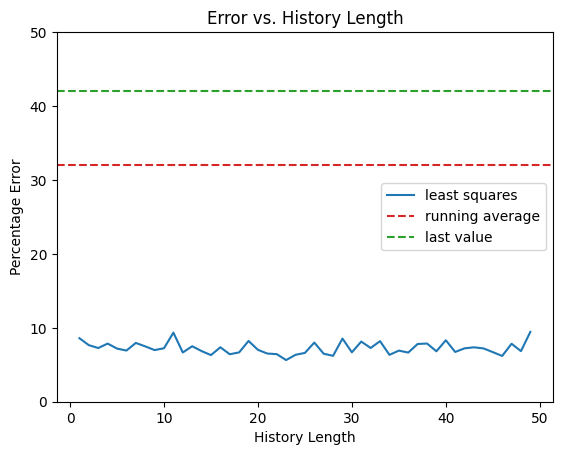

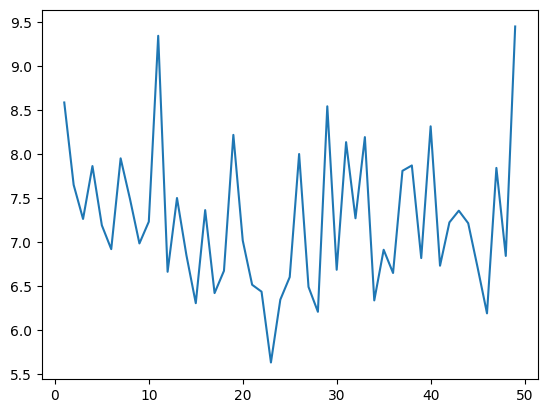

In [33]:
plt.figure()
plt.plot(window_lengths, np.array(errors), c="tab:blue", label="least squares")
plt.xlabel("History Length")
plt.ylabel("Percentage Error")
plt.title("Error vs. History Length")
plt.axhline(y=32, c="tab:red", linestyle="--", label="running average")
plt.axhline(y=42, c="tab:green", linestyle="--", label="last value")
plt.ylim(0, 50)
plt.legend()
plt.show()

plt.figure()
plt.plot(window_lengths, np.array(errors), c="tab:blue", label="least squares")
plt.show()

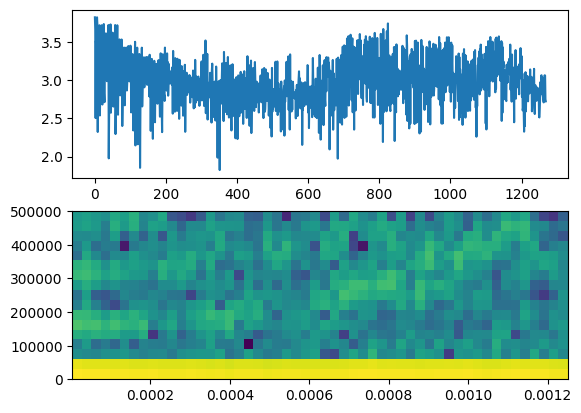

In [40]:
fig, (ax1, ax2) = plt.subplots(nrows=2)

ax1.plot(segmentation_dataset.data[0])
_ = ax2.specgram(segmentation_dataset.data[0], NFFT=32, Fs=1_000_000, noverlap=8)